This notebook demonstrates steps of creating a pipeline of model training and testing

<!-- %pip install -q transformers datasets evaluate -->

In [ ]:
!git clone https://github.com/OopsWrongCode/nlp-project.git

In [ ]:
%cd nlp-project/

In [ ]:
%pip install -q transformers

In [ ]:
import random
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# from datasets import Dataset

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
train = pd.read_csv('/kaggle/working/nlp-project/data/train.csv')
test = pd.read_csv('/kaggle/working/nlp-project/data/test.csv')
validation = pd.read_csv('/kaggle/working/nlp-project/data/valid.csv')

In [ ]:
train['token_count'] = [len(sentence.split()) for sentence in train['text']]
train['text_length'] = [len(seq) for seq in train['text']]

In [ ]:
train.head()

In [ ]:
validation.head()

In [ ]:
from sklearn.preprocessing import LabelEncoder

mbti_types = train['label'].unique().tolist()

label_encoder = LabelEncoder()
label_encoder.fit(mbti_types)

train['label'] = label_encoder.transform(train['label'])
validation['label'] = label_encoder.transform(validation['label'])

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

class MBTIDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        text = str(self.texts[index])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        if self.labels is not None:
            label = self.labels[index]
            return {
                'input_ids': encoding['input_ids'].squeeze(0),  # (max_len)
                'attention_mask': encoding['attention_mask'].squeeze(0),  # (max_len)
                'labels': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                'input_ids': encoding['input_ids'].squeeze(0),  # (max_len)
                'attention_mask': encoding['attention_mask'].squeeze(0),  # (max_len)
            }

    def __len__(self):
        return len(self.texts)

In [ ]:
print(f"Max len = {np.max(train['token_count'])}\nMin len = {np.min(train['token_count'])}\nAvg len = {np.round(np.mean(train['token_count']), 2)}")

In [ ]:
BATCH_SIZE = 64
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = MBTIDataset(texts=train['text'].tolist(), labels=train['label'].tolist(), tokenizer=tokenizer, max_len=48)
test_dataset = MBTIDataset(texts=test['text'].tolist(),labels=test['label'].tolist(), tokenizer=tokenizer, max_len=48)
validation_dataset = MBTIDataset(texts=validation['text'].tolist(), labels=validation['label'].tolist(), tokenizer=tokenizer, max_len=48)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
class MyLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim=6, num_layers=1, bidirectional=False, dropout=0.3, fc_dropout=0.3):
        super(MyLSTM, self).__init__()

        self.lstm = nn.LSTM(
            input_size=embedding_dim,  # 768
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        # LAYER 2: Fully-connected

        self.fc_dropout = nn.Dropout(fc_dropout)
        self.fc = nn.Linear(
            hidden_dim * (2 if bidirectional else 1),
            output_dim
        )
        

    def forward(self, bert_embeddings):  # [batch_size, seq_len, embedding_dim]
        lstm_output, (h_n, c_n) = self.lstm(bert_embeddings)

        if self.lstm.bidirectional:
            h_final = torch.cat((h_n[-2], h_n[-1]), dim=1)
        else:
            h_final = h_n[-1]

        out = self.fc(h_final)
        return out

In [ ]:
class MyGRU(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim=6, num_layers=1, bidirectional=False, dropout=0.3, fc_dropout=0.2):
        super(MyGRU, self).__init__()

        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        self.fc_dropout = nn.Dropout(fc_dropout)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)

    def forward(self, x): 
        gru_output, h_n = self.gru(x)

        if self.gru.bidirectional:
            h_final = torch.cat((h_n[-2], h_n[-1]), dim=1)
        else:
            h_final = h_n[-1]

        out = self.fc(h_final)
        return out

In [ ]:
from transformers import AutoModel

bert = AutoModel.from_pretrained("bert-base-uncased").to(DEVICE)

In [ ]:
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau


VOCAB_SIZE = len(tokenizer)

gru_model = MyGRU(embedding_dim=768, hidden_dim=128, output_dim=6, num_layers=5, dropout=0.3, bidirectional=True).to(DEVICE)

class_weights = compute_class_weight('balanced', classes=np.unique(train.label), y=train.label)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

# Обновляем loss function с учетом весов
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
gru_optimizer = optim.Adam(gru_model.parameters(), lr=0.001)
gru_scheduler = ReduceLROnPlateau(gru_optimizer, patience=3, factor=0.1)

In [ ]:
class_weights

In [ ]:
# class_weights[5] = class_weights[5] * 1.1

In [ ]:
lstm_model = MyLSTM(embedding_dim=768, hidden_dim=128, output_dim=6, num_layers=3, dropout=0.5, bidirectional=True).to(DEVICE)

lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001, weight_decay=0.00001)
lstm_scheduler = ReduceLROnPlateau(lstm_optimizer, patience=3, factor=1e-2)

In [ ]:
import copy

class EarlyStopper:
    def __init__(self, model, patience=3, min_delta=0, restore_best_weights=True, save_weights=False):
        self.model = model
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.best_weights = None
        self.restore_best_weights = restore_best_weights
        self.save_weights = save_weights

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss - self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_weights = copy.deepcopy(self.model.state_dict())

        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.restore_best_weights and self.best_weights is not None:
                    self.model.load_state_dict(self.best_weights)
                    if self.save_weights:
                        torch.save(self.best_weights, f'{self.model.__class__.__name__}_best_weights.pt')
                        print(f"Weights has been saved")
                return True

        return False

# source: https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch

In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

EPOCHS = 16
MODEL = lstm_model
OPTIMIZER = lstm_optimizer
lr_history = []
early_stopper = EarlyStopper(patience=3, model=MODEL, min_delta=0.01, save_weights=False)

for epoch in range(EPOCHS):
    MODEL.train() #replace
    running_loss = 0.0

    for batch in train_loader:
        OPTIMIZER.zero_grad() # replace

        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        with torch.no_grad():  # BERT embed
            bert_output = bert(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = bert_output.last_hidden_state  # [batch_size, seq_len, 768]

        outputs = MODEL(embeddings) #replace
        loss = loss_fn(outputs, labels)

        loss.backward()
        OPTIMIZER.step() #replace

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # === VALIDATION ===
    MODEL.eval() #replace
    val_preds = []
    val_labels = []
    val_loss_total = 0.0

    with torch.no_grad():
        for batch in validation_loader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            bert_output = bert(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = bert_output.last_hidden_state

            outputs = MODEL(embeddings) #replace
            loss = loss_fn(outputs, labels)

            val_loss_total += loss.item()

            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss_total / len(validation_loader)
    val_acc = accuracy_score(val_labels, val_preds)

    lstm_scheduler.step(avg_val_loss) # replace 
    current_lr = OPTIMIZER.param_groups[0]['lr'] #replace
    lr_history.append(current_lr)

    if early_stopper.early_stop(avg_val_loss):             
        print(f"Early stopping at epoch {epoch+1}")
        break


    print(f"Epoch {epoch+1}/{EPOCHS} — Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

class_report = classification_report(val_labels, val_preds, target_names=[str(i) for i in range(6)])
print(f"Classification Report:\n{class_report}")

print("Train finished")

Epoch 1/16 — Train Loss: 1.6366 | Val Loss: 1.4363 | Val Acc: 0.4429
Epoch 2/16 — Train Loss: 1.2374 | Val Loss: 0.9540 | Val Acc: 0.5591
Epoch 3/16 — Train Loss: 0.8979 | Val Loss: 0.8419 | Val Acc: 0.6572
Epoch 4/16 — Train Loss: 0.7470 | Val Loss: 0.6806 | Val Acc: 0.7563
Epoch 5/16 — Train Loss: 0.6729 | Val Loss: 0.6521 | Val Acc: 0.7533
Epoch 6/16 — Train Loss: 0.6102 | Val Loss: 0.5575 | Val Acc: 0.7773
Epoch 7/16 — Train Loss: 0.5621 | Val Loss: 0.5667 | Val Acc: 0.7733
Epoch 8/16 — Train Loss: 0.5408 | Val Loss: 0.5456 | Val Acc: 0.7643
Epoch 9/16 — Train Loss: 0.5129 | Val Loss: 0.5685 | Val Acc: 0.7923
Epoch 10/16 — Train Loss: 0.4878 | Val Loss: 0.5464 | Val Acc: 0.7738
Early stopping at epoch 11
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       274
           1       0.72      0.73      0.73       212
           2       0.89      0.75      0.82       703
           3       0.52      0.79      0.6

In [26]:
if early_stopper.best_weights is not None:
    MODEL.load_state_dict(early_stopper.best_weights)
    print("✅ Best weights loaded after training")
else:
    print("⚠️ No best weights were saved (maybe early stop didn’t trigger?)")

✅ Best weights loaded after training


In [22]:
MODEL.load_state_dict(early_stopper.best_weights)
MODEL.eval()

test_preds = []
test_labels = []
test_loss_total = 0.0

with torch.no_grad():

    for batch in test_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        bert_output = bert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = bert_output.last_hidden_state

        outputs = MODEL(embeddings)
        loss = loss_fn(outputs, labels)
        test_loss_total += loss.item()


        preds = torch.argmax(outputs, dim=1)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())



avg_test_loss = test_loss_total / len(test_loader)
test_acc = accuracy_score(test_labels, test_preds)

print(f"Validation Loss: {avg_test_loss:.4f} | Validation Accuracy: {test_acc:.4f}")

Validation Loss: 5.5650 | Validation Accuracy: 0.1910


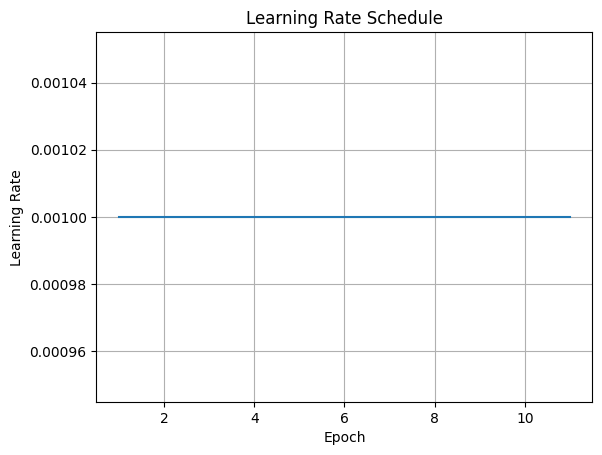

In [23]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(lr_history) + 1), lr_history)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.grid(True)
plt.show()

In [24]:
class HybridNN:
    pass